In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import os


In [ ]:
#!pip install tensorflow
#!pip install pydot
#!pip install graphviz



In [ ]:
# Import necessary libraries
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from keras.layers import Reshape, concatenate
from keras.utils import plot_model


from sklearn.model_selection import train_test_split
import random

In [ ]:
#from google.colab import files
 
#files.upload()  

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
!ls -l "/content/drive/MyDrive/TFM"

total 1703
drwx------ 2 root root    4096 Jan 24 08:49 00_bs_db
drwx------ 2 root root    4096 Jan 24 14:48 02_paintings
drwx------ 2 root root    4096 Jan 30 13:10 02_paintings_2bs
drwx------ 2 root root    4096 Jan 26 22:18 02_paintings_plus
drwx------ 2 root root    4096 Jan 24 14:48 03_paintings_out
drwx------ 2 root root    4096 Jan 30 13:11 03_paintings_out_2bs
drwx------ 2 root root    4096 Jan 26 22:18 03_paintings_out_plus
drwx------ 2 root root    4096 Jan 30 13:04 04_models
drwx------ 2 root root    4096 Jan 24 14:48 05_test
drwx------ 2 root root    4096 Jan 28 23:53 05_test_2bs
drwx------ 2 root root    4096 Jan 27 21:16 05_test_plus
drwx------ 2 root root    4096 Jan 28 21:23 0_bs
-rw------- 1 root root 1544613 Jan 24 08:29 1_paints_generator.ipynb
-rw------- 1 root root  145328 Jan 24 00:06 model_test.ipynb
drwx------ 2 root root    4096 Jan 30 09:05 versiones


In [ ]:
#load arrays 4d:
#  .-images (train/test)
#  .-results (train/test)

def load_images(path, gray=True):

    filelist= [file for file in os.listdir(path) if file.endswith('.png')]
    filelist.sort()    
    
    for imfile in filelist:      

        paint_id=int(imfile[7:11])

        if gray==True:
          image=cv2.imread(path + imfile,cv2.IMREAD_GRAYSCALE)/255.
        else:
          image = cv2.imread(path + imfile)
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)/255. #to rgb scale y normalizado        


        image=np.expand_dims(image,axis=0)
        
        if paint_id == 1:
            data = image.copy()
        else:
            data = np.concatenate((data, image), axis=0)

    return data

def load_results(path):

    filelist= [file for file in os.listdir(path) if file.endswith('.csv')]
    filelist.sort()
    
    for imfile in filelist:      

        paint_id=int(imfile[7:11])
        result = np.loadtxt(path + imfile, delimiter=',')  
        
        if  np.max(np.unique(result)) != 0:   
          result=result/np.max(np.unique(result) ) # in order to obtain a range for the output values betwen 0 and 1. 

        result=np.expand_dims(result,axis=0)
        
        if paint_id == 1:
            target = result.copy()
        else:
            target=np.concatenate((target, result), axis=0)

    return target


In [ ]:
TFM_path='/content/drive/MyDrive/TFM/'

#800 train, 200 test
paint_path= TFM_path + '02_paintings/'
paint_path_out= TFM_path +  '03_paintings_out/'

paint_path_in_test= TFM_path + '05_test/IN/'
paint_path_out_test= TFM_path + '05_test/OUT/'

path_model= TFM_path + '04_models/'

In [ ]:
# retrain with some more images 2.000 train, 400 test
paint_path_plus= TFM_path + '02_paintings_plus/'
paint_path_out_plus= TFM_path +  '03_paintings_out_plus/'

paint_path_in_test_plus= TFM_path + '05_test_plus/IN/'
paint_path_out_test_plus= TFM_path + '05_test_plus/OUT/'

#path_model= TFM_path + '04_models_plus/'

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Jan 28 10:43:46 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    30W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#generate X_train, y_train, validation_data=(X_val, y_val)
#___________________________________________________________

data = load_images(path=paint_path,gray=True)
target = load_results(path=paint_path_out)

X_test = load_images(path=paint_path_in_test, gray=True)
y_test= load_results(path=paint_path_out_test)


data_rgb = load_images(path=paint_path,gray=False)
X_test_rgb = load_images(path=paint_path_in_test, gray=False)

In [ ]:
data.shape

(800, 128, 128)

In [ ]:
#https://blog.finxter.com/how-to-shuffle-two-arrays-in-unison-in-python/
#import numpy as np
# Given
#arr_1 = np.array([[1, 1], [2, 2], [3, 3]])
#arr_2 = np.array([1, 2, 3])
# shuffling the two arrays in unison
#shuffler = np.random.permutation(len(arr_1))
#arr_1_shuffled = arr_1[shuffler]
#arr_2_shuffled = arr_2[shuffler]
#print(arr_1_shuffled)
#print(arr_2_shuffled)

# Models to be tested

In [ ]:
# Import necessary libraries for colour RGB input
#https://towardsdatascience.com/types-of-convolutions-in-deep-learning-717013397f4d
#regresion linear compile(optimizer= RMSprop(learning_rate=0.003) , metrics=[mae,mape], loss=mse)

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input,AveragePooling2D

from keras import optimizers
from keras import losses
from keras import metrics


def model_256(summary, gray=True):

  # Define the architecture of the model
  if gray == True:
    input_shape = (256, 256,1)  # images are 256x256 gray scale
  else:
    input_shape = (256, 256, 3) # images are 256x256 RGB images
  
  model = Sequential()

  model.add(Conv2D(64, (3,3), activation='relu', padding='same', input_shape=input_shape))
  model.add(MaxPooling2D((2,2)))
  
  model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
  model.add(MaxPooling2D((2,2)))
  model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
  model.add(MaxPooling2D((2,2)))

  model.add(UpSampling2D((2,2)))
  model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
  model.add(UpSampling2D((2,2)))
  model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
  model.add(UpSampling2D((2,2)))
  model.add(Conv2D(1, (3,3), activation='linear', padding='same'))  
  
  if summary == True:
    model.summary()

  return model


def model_128(summary, gray=True):

  # Define the architecture of the model
  if gray == True:
    input_shape = (128, 128,1)  # images are 128x128 gray scale
  else:
    input_shape = (128, 128, 3) # images are 128x128 RGB images

  model = Sequential()

  model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape))
  model.add(MaxPooling2D((2,2)))
  model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
  model.add(MaxPooling2D((2,2)))  
  model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
  model.add(MaxPooling2D((2,2)))

  model.add(UpSampling2D((2,2)))
  model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
  model.add(UpSampling2D((2,2)))
  model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
  model.add(UpSampling2D((2,2)))
  model.add(Conv2D(1, (3,3), activation='linear', padding='same')) 
 
  if summary == True:
    model.summary()

  return model


def model_128_avgpooling(summary, gray=True):

 # Define the architecture of the model
  if gray == True:
    input_shape = (128, 128,1)  # images are 128x128 gray scale
  else:
    input_shape = (128, 128, 3) # images are 128x128 RGB images

  model = Sequential()

  model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape))
  model.add(AveragePooling2D((2,2)))
  model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
  model.add(AveragePooling2D((2,2)))  
  model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
  model.add(AveragePooling2D((2,2)))

  model.add(UpSampling2D((2,2)))
  model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
  model.add(UpSampling2D((2,2)))
  model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
  model.add(UpSampling2D((2,2)))
  model.add(Conv2D(1, (3,3), activation='linear', padding='same')) 
 
  if summary ==True:
    model.summary()

  return model


In [ ]:
#https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy

# Train the model on your dataset
#history=model.fit(X_train, y_train, validation_data=(X_val, y_val),  batch_size=32, epochs=100)

# Use the trained model to make predictions on new images
#predicted_depths = model.predict(X_test)

#You can estimate the largest batch size using:Max batch size= available GPU memory bytes / 4 / (size of tensors + trainable parameters)

In [ ]:

def plot_metric(history, metric, batch_size):

  history_dict = history.history
  values = history_dict[metric]
  if 'val_' + metric in history_dict.keys():  
      val_values = history_dict['val_' + metric]

  epochs = range(1, len(values) + 1)

  if 'val_' + metric in history_dict.keys():  
      plt.plot(epochs, val_values, label='Validation')
  plt.semilogy(epochs, values, label='Training')

  if 'val_' + metric in history_dict.keys():  
      plt.title('Training and validation %s (batch_size: %d) ' % (metric,batch_size))
  else:
      plt.title('Training %s' % metric)
  plt.xlabel('Epochs')
  plt.ylabel(metric.capitalize())
  #plt.ylim([0, 1])
  plt.legend()

  plt.show()  


# Functions to train the models and register the outputs in a data frame for later evaluation

In [ ]:
# Exec model

#create a df with the summary of the training
def df_history(history, model, batch_size,model_id):

  df_model = pd.DataFrame(history.history)
  df_model['model_name'] = model.name   
  df_model['epoch'] = df_model.index + 1
  df_model['total_epoch'] = history.params['epochs']
  df_model['batchsize'] = batch_size
  df_model['Ntrain_v_batchsize'] = history.params['steps']
  df_model['model_in_code'] = model_id
  
  return df_model


#executing the model 
def exec_model(gray, summary, batch_size, epochs, verbose, model_id='model_128'):

  if model_id=='model_128':
    model = model_128 (summary,gray ) 

  elif  model_id=='model_128_2bs':
    model = model_128 (summary,gray ) 
    
  elif model_id=='model_128avgpool':
    model =  model_128_avgpooling  (summary,gray )
     

  model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

  if model_id=='model_128_2bs':

    if gray==True:    
      X_train, X_val, y_train, y_val = train_test_split(data_2bs, target_2bs, test_size=0.2, random_state=42)
    else:
      X_train, X_val, y_train, y_val = train_test_split(data_rgb_2bs, target_2bs, test_size=0.2, random_state=42)

  else:  

    if gray==True:    
      X_train, X_val, y_train, y_val = train_test_split(data, target, test_size=0.2, random_state=42)
    else:
      X_train, X_val, y_train, y_val = train_test_split(data_rgb, target, test_size=0.2, random_state=42)

  history = model.fit(X_train, y_train, validation_data= (X_val, y_val),  batch_size=batch_size, epochs=epochs,verbose=verbose)

  plot_metric(history,metric='loss',batch_size=batch_size)
  plot_metric(history,metric='mae',batch_size=batch_size)
  
  df_model=df_history (history, model, batch_size,model_id)

  return df_model, model



# Hyperparameter tuning: batch_size /epochs

In [ ]:
# hyperparameter bath_size/epochs
#model_128_______________________________________________________________

def model_training(gray_scale=True, model_id = 'model_128'):     

  rounds=0 
  for batch_size in [6,12,32,64]:
    for epochs in [10,20,50,100]: 
      if rounds == 0: summary_model=True
      else: summary_model=False

      df_training_round, model_round = exec_model(gray = gray_scale, summary= summary_model, batch_size=batch_size,epochs=epochs,verbose=0,model_id=model_id) 

      if rounds == 0:
        df_training=df_training_round
      else:
        df_training = df_training.append(df_training_round, ignore_index=True)

      del df_training_round
      
      #saving models
      exec(f'model_round.save(path_model + model_id + "gray_{str(gray_scale)}_b{batch_size}_e{epochs}.h5")')  
  
      rounds +=1

  #training information to df repository
  exec(f'df_training.to_csv(path_model + model_id + "gray_{str(gray_scale)}.csv", index=False)')   


def retrain_model (gray_scale, model ,batch_size,epochs,verbose,model_='model_128_retrained' ):#model_id = 'model_128_retrained'

  model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
      
  
  summary_model=True      

  df_training_round, model_round = exec_model(gray = gray_scale, summary= summary_model, batch_size=batch_size,epochs=epochs,verbose=1) 

  df_training=df_training_round
  del df_training_round
      
  #saving model
  exec(f'model_round.save(path_model + model_id + "gray_retrained{str(gray_scale)}_b{batch_size}_e{epochs}.h5")')  

  #training information to df repository
  exec(f'df_training.to_csv(path_model + model_id + "gray_retrained{str(gray_scale)}.csv", index=False)')   




Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 128)     

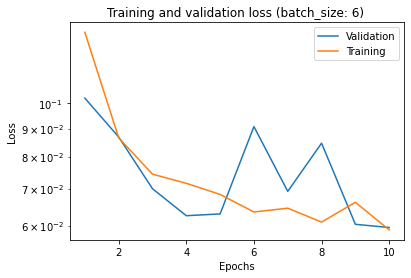

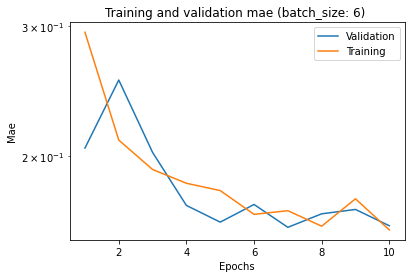

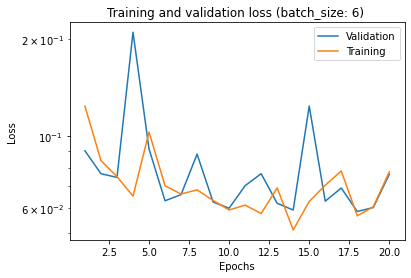

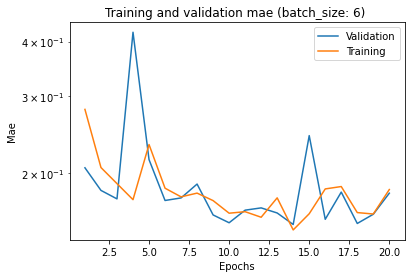

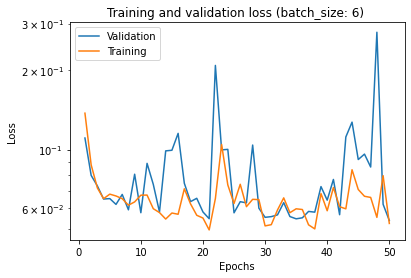

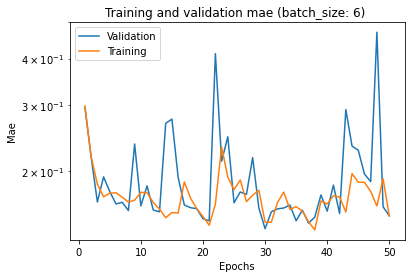

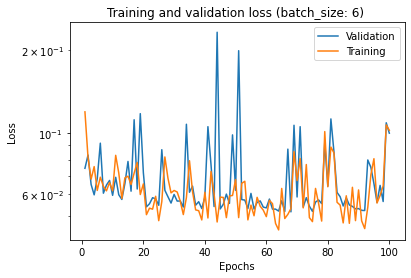

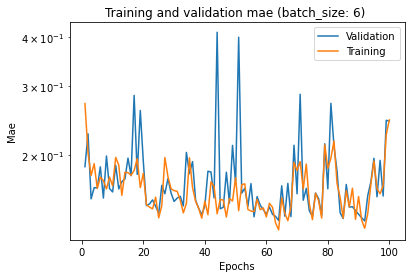

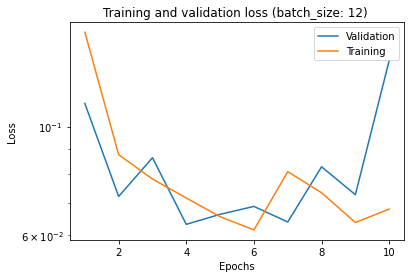

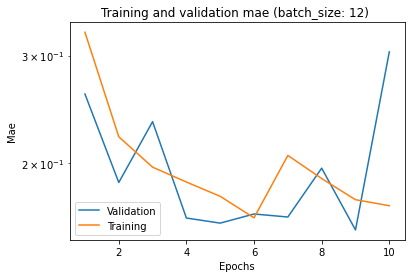

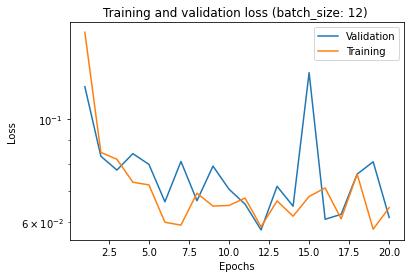

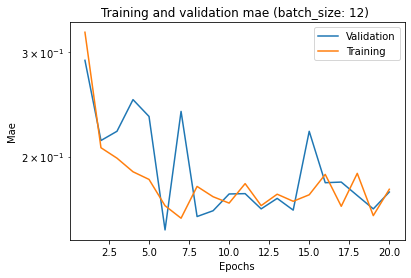

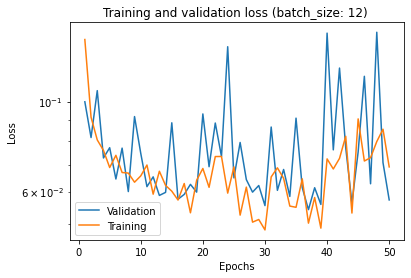

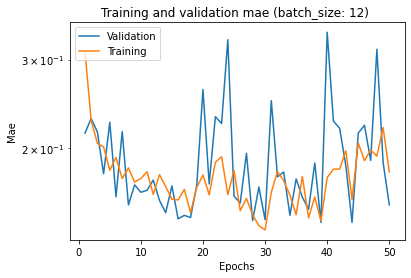

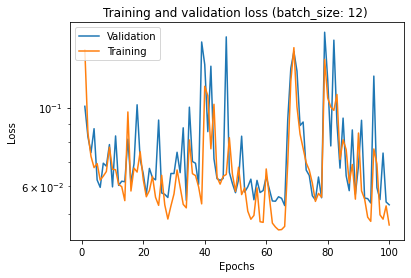

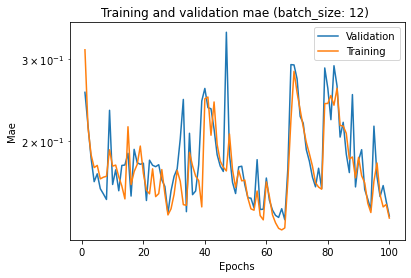

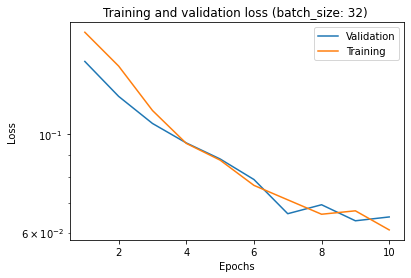

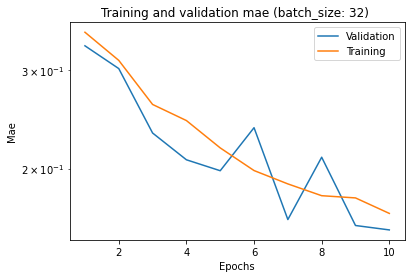

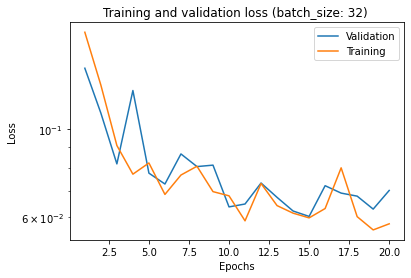

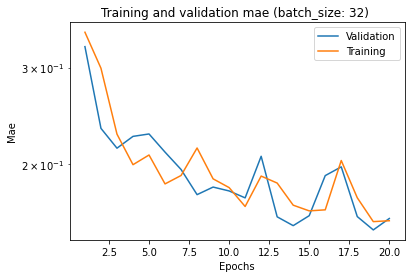

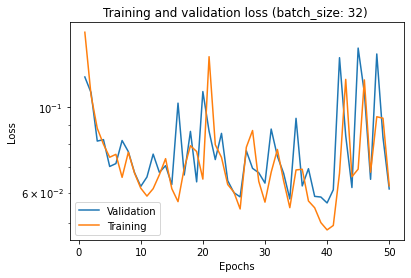

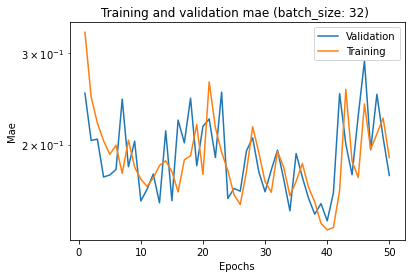

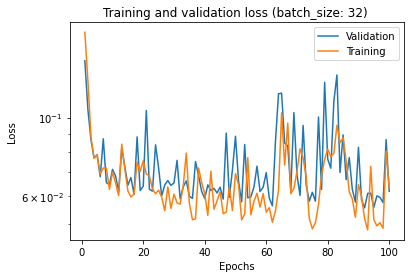

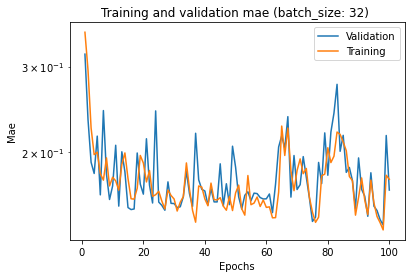

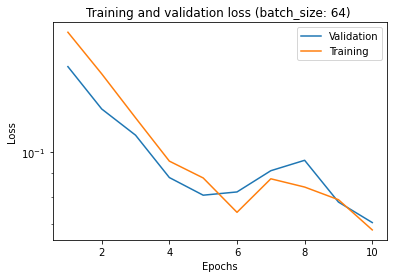

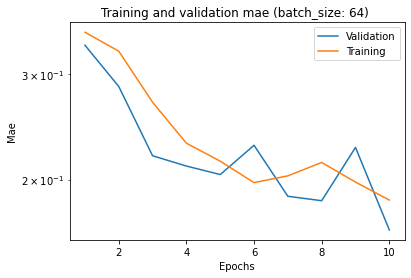

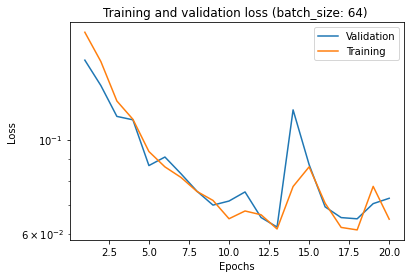

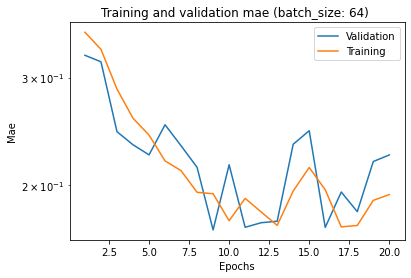

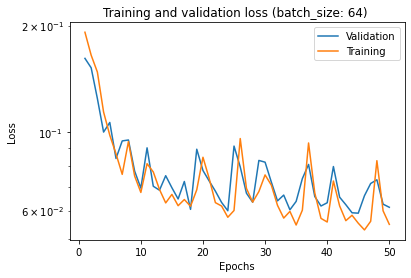

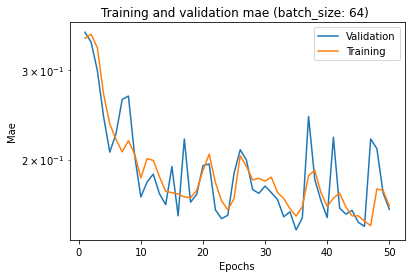

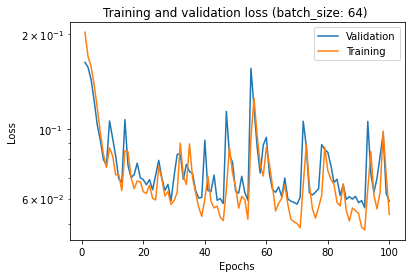

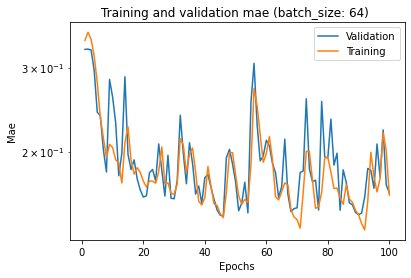

In [ ]:
#train model
model_training(gray_scale=True, model_id='model_128')



Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_102 (Conv2D)         (None, 128, 128, 32)      320       
                                                                 
 average_pooling2d (AverageP  (None, 64, 64, 32)       0         
 ooling2D)                                                       
                                                                 
 conv2d_103 (Conv2D)         (None, 64, 64, 64)        18496     
                                                                 
 average_pooling2d_1 (Averag  (None, 32, 32, 64)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_104 (Conv2D)         (None, 32, 32, 128)       73856     
                                                                 
 average_pooling2d_2 (Averag  (None, 16, 16, 128)    

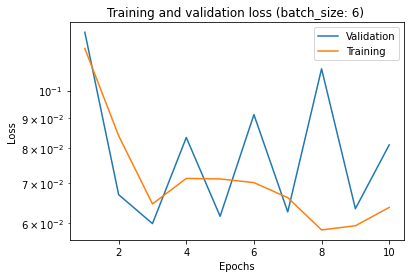

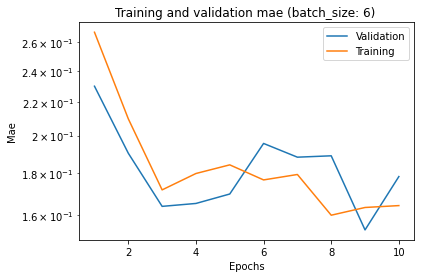

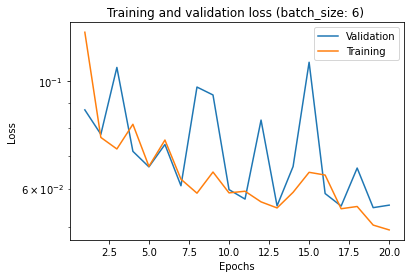

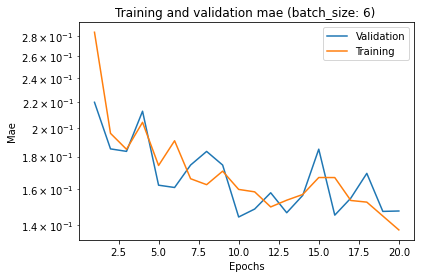

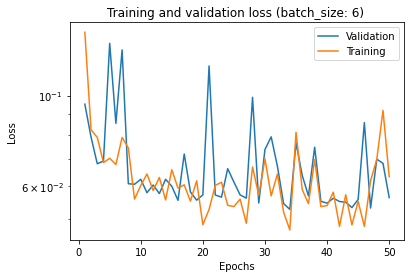

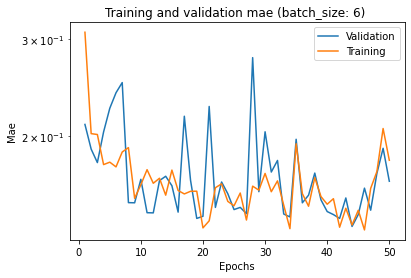

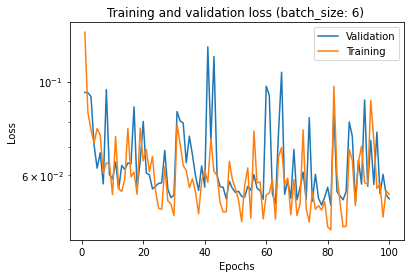

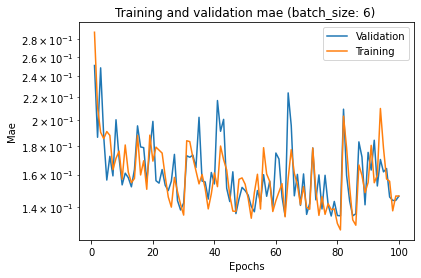

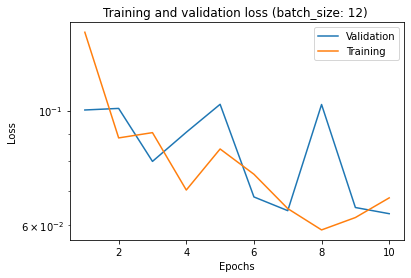

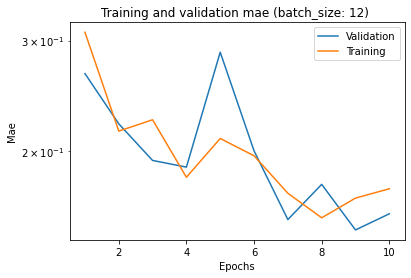

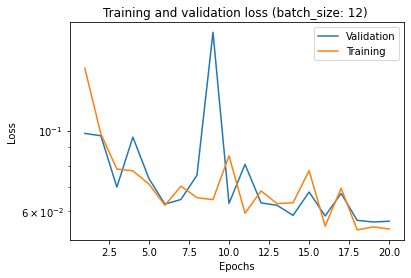

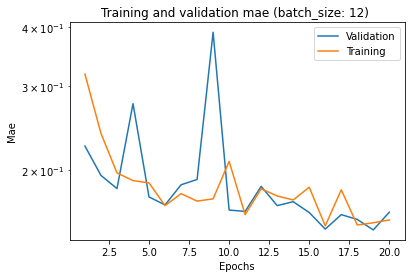

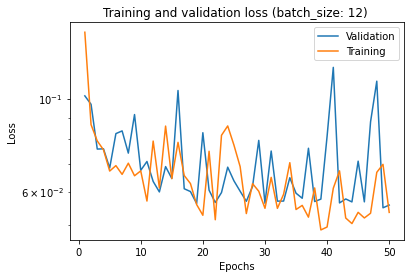

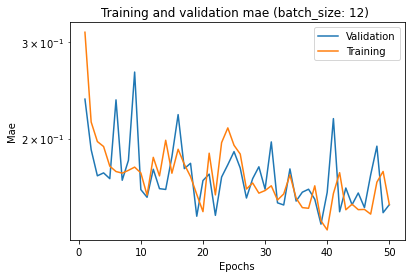

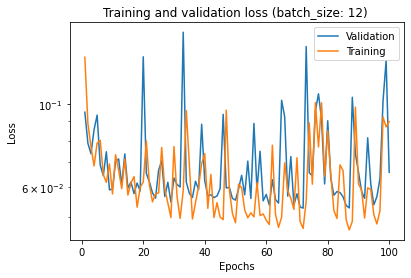

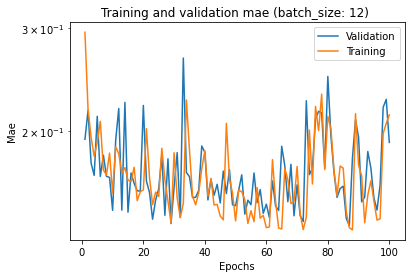

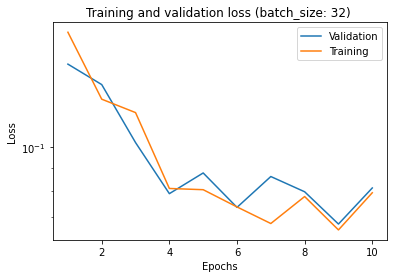

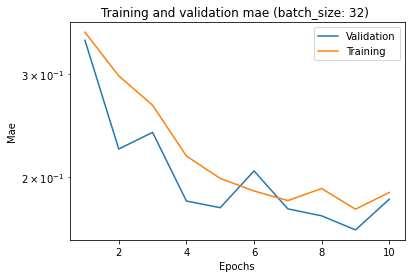

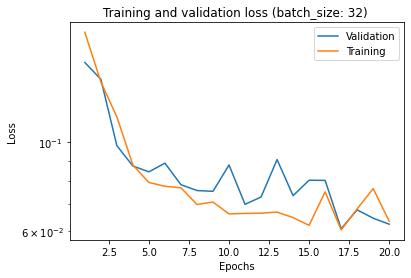

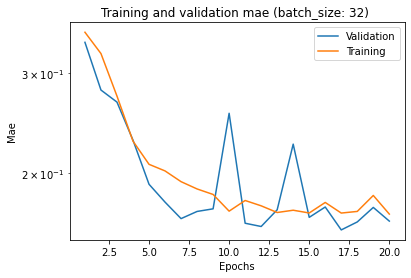

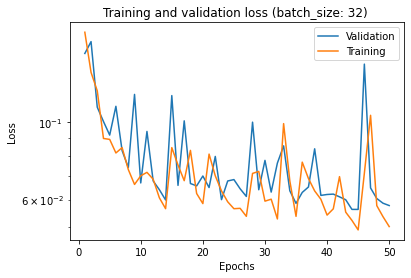

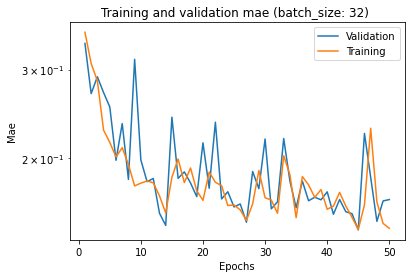

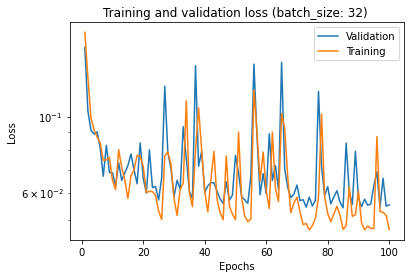

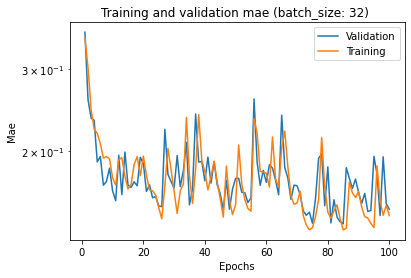

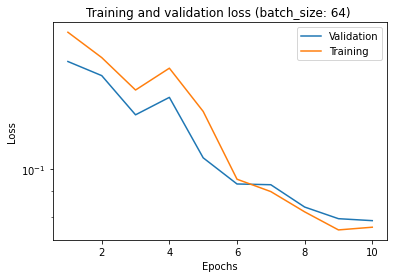

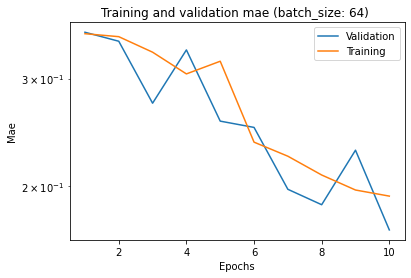

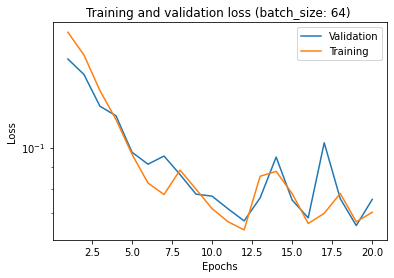

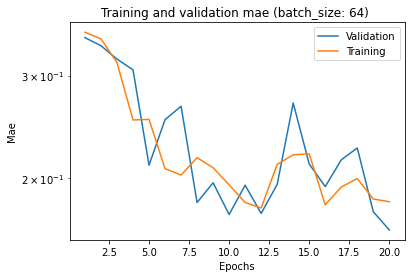

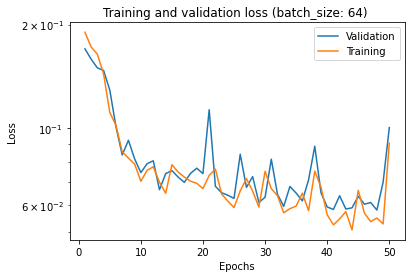

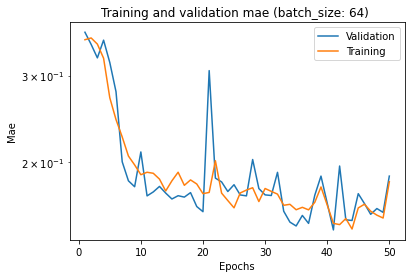

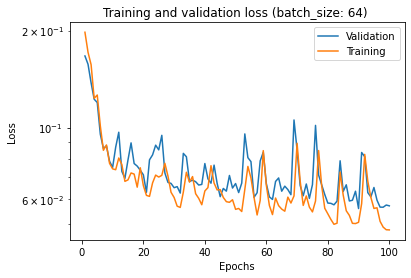

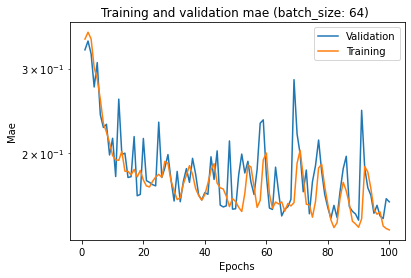

In [ ]:
model_training(gray_scale=True, model_id='model_128avgpool')

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_198 (Conv2D)         (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_199 (Conv2D)         (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_200 (Conv2D)         (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_53 (MaxPoolin  (None, 16, 16, 128)    

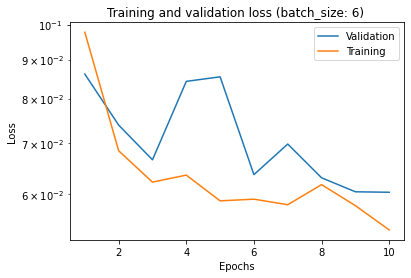

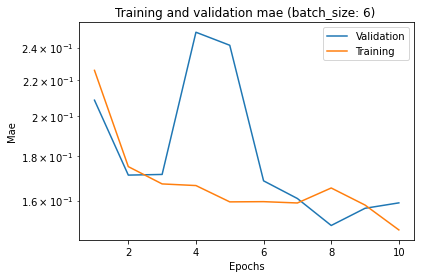

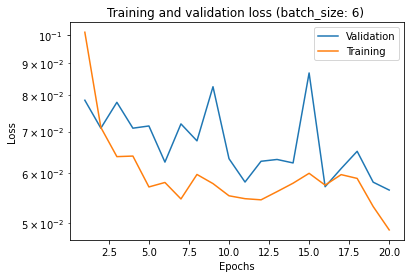

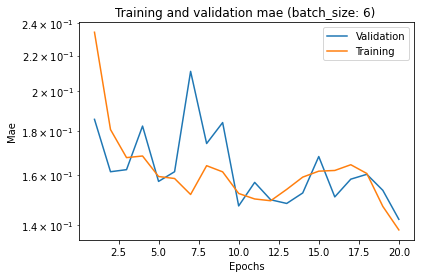

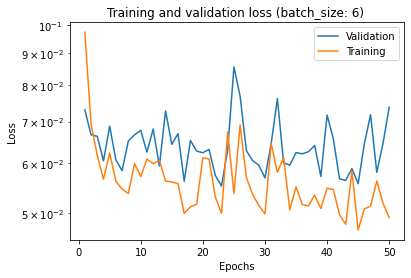

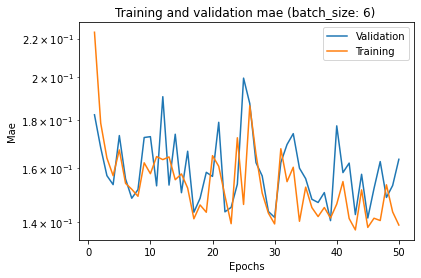

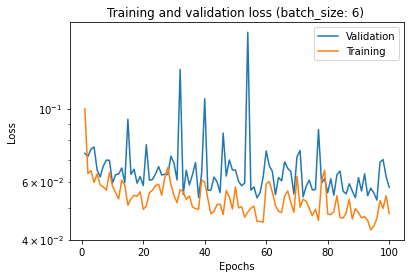

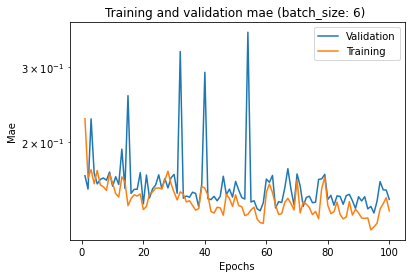

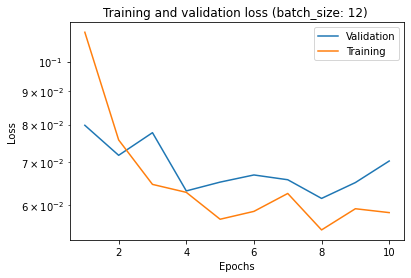

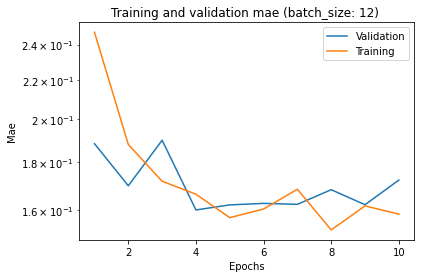

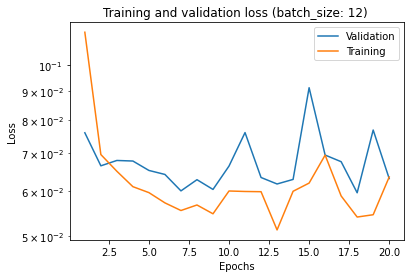

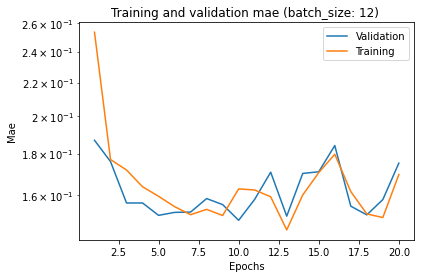

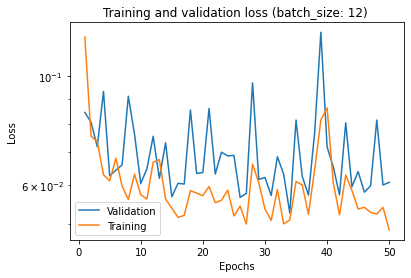

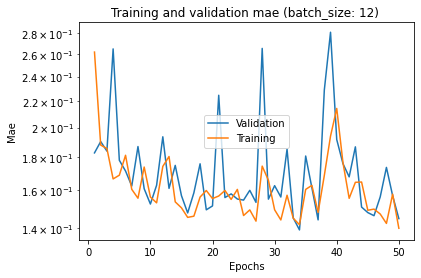

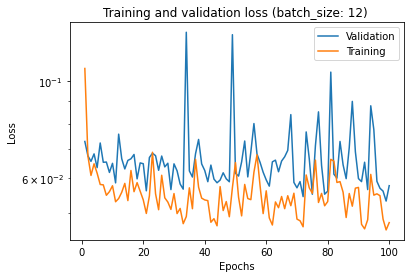

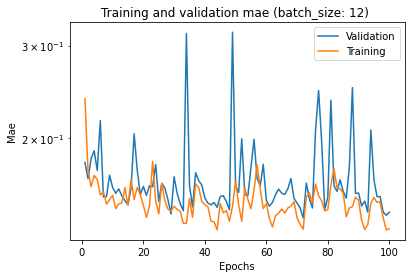

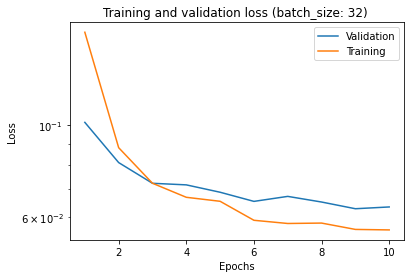

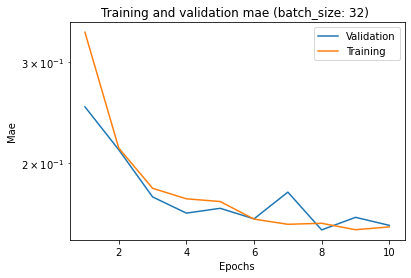

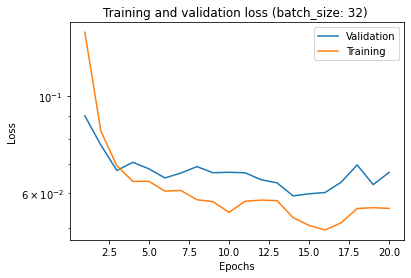

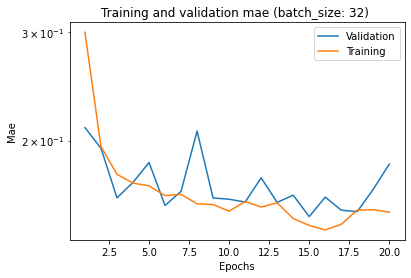

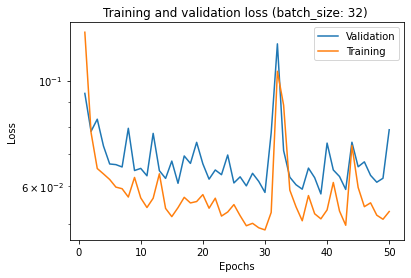

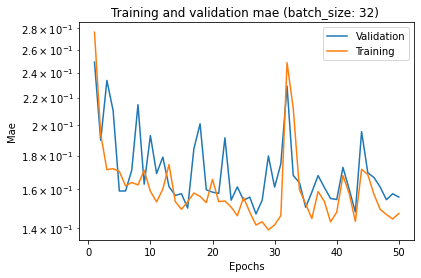

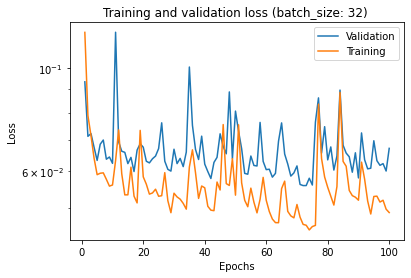

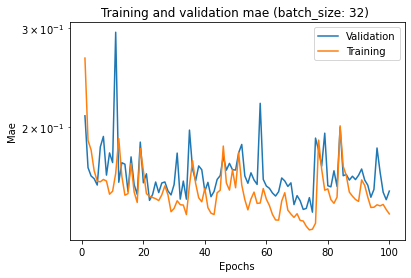

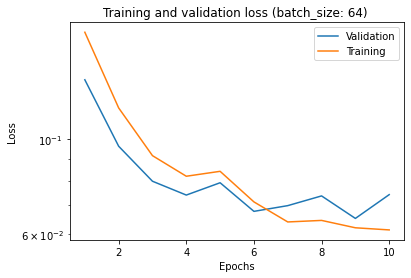

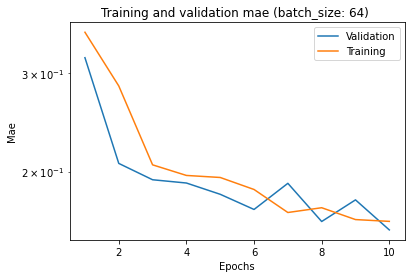

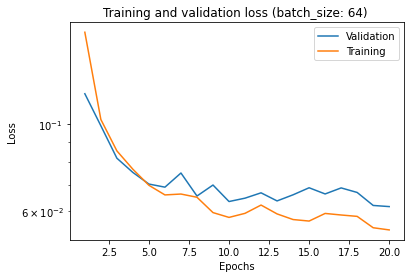

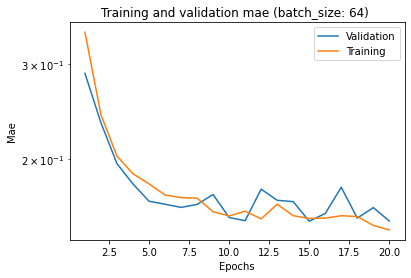

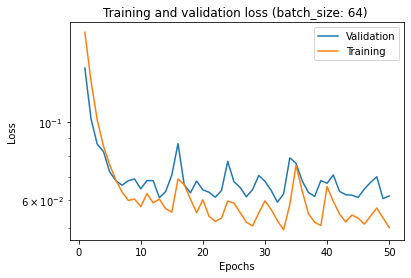

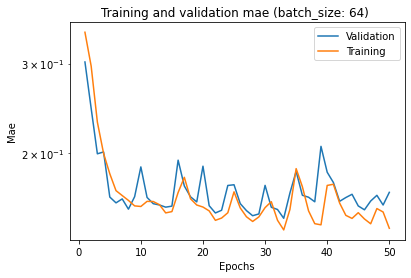

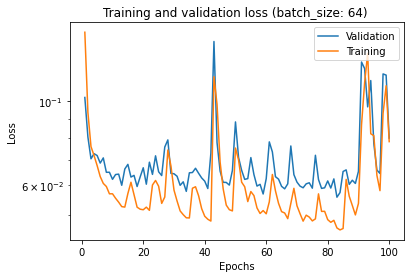

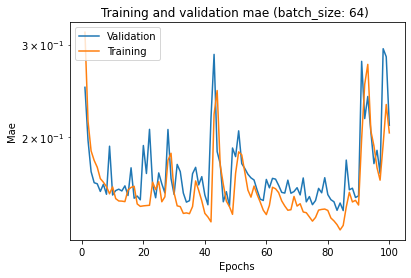

In [ ]:
#load data in 3 channels
data_rgb = load_images(path=paint_path,gray=False)
X_test_rgb = load_images(path=paint_path_in_test, gray=False)

model_training(gray_scale=False, model_id='model_128')

<ipython-input-7-b98353c41688>:39: RuntimeWarning: invalid value encountered in true_divide
  result=result/np.max(np.unique(result) ) # in order to obtain a range for the output values betwen 0 and 1.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 128)      0

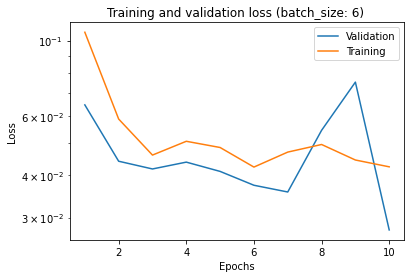

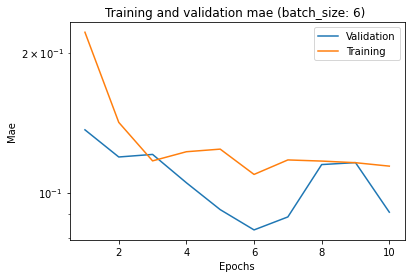

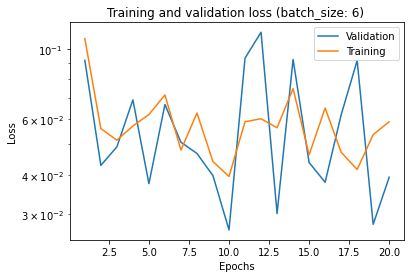

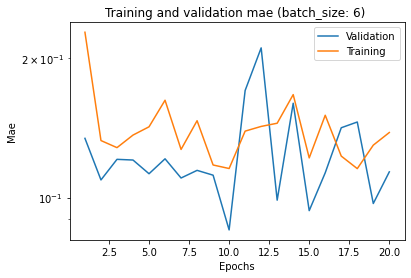

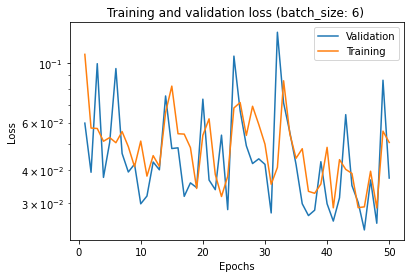

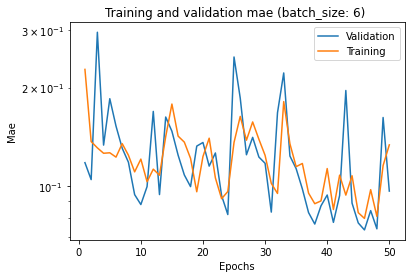

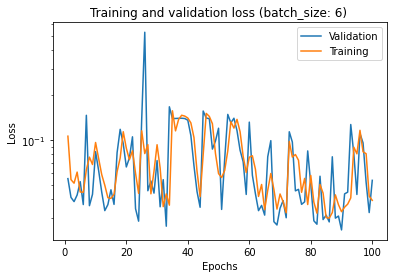

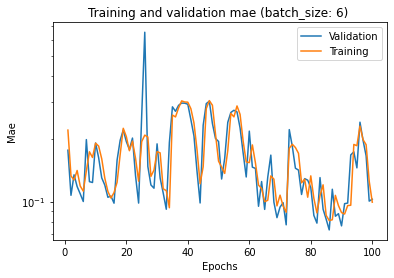

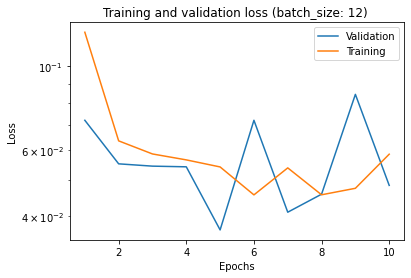

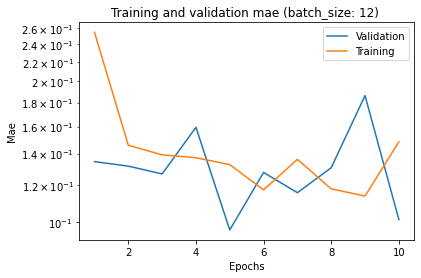

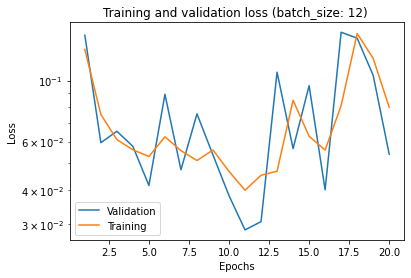

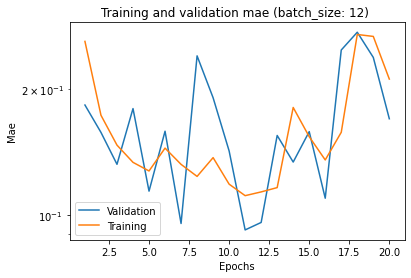

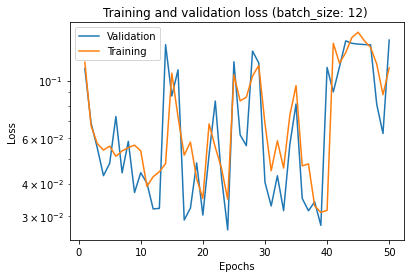

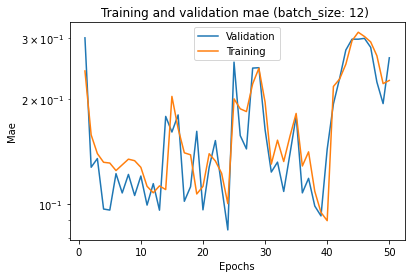

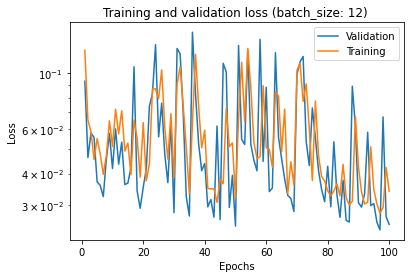

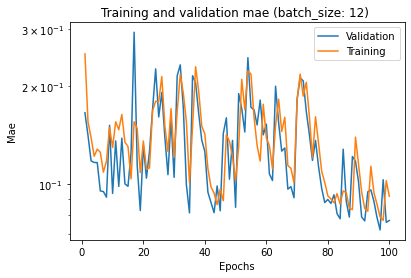

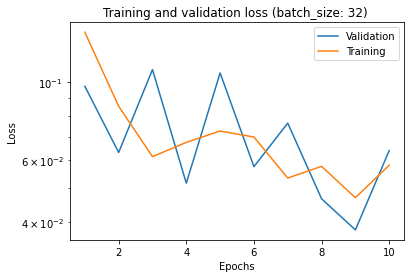

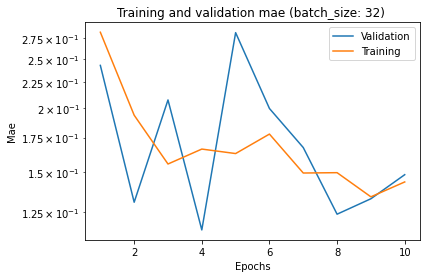

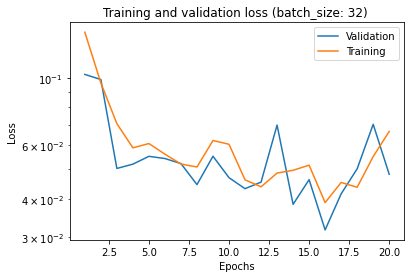

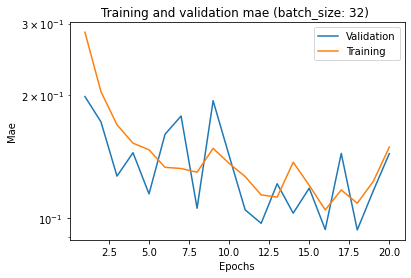

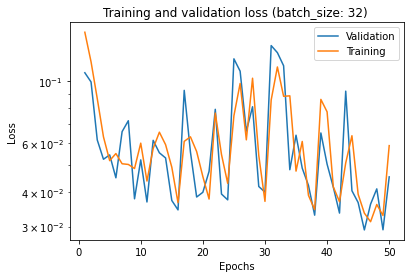

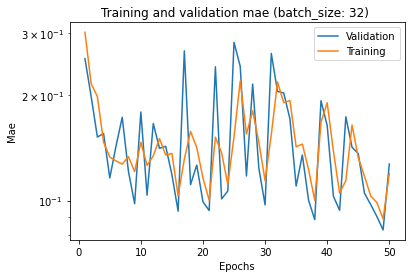

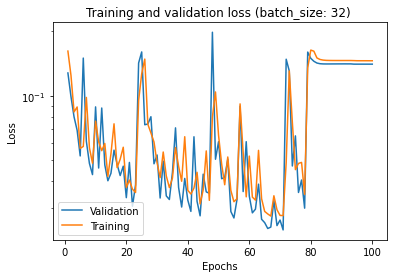

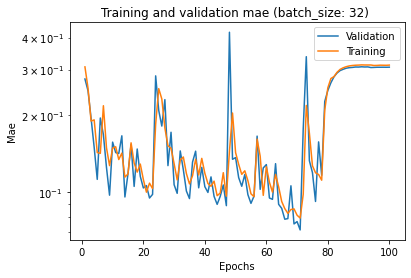

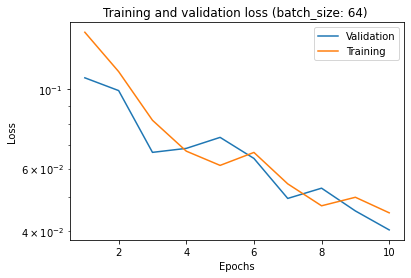

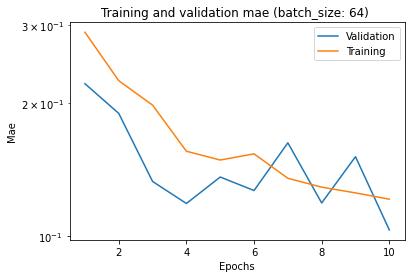

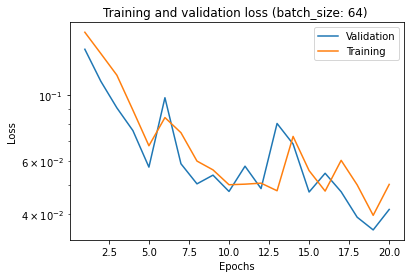

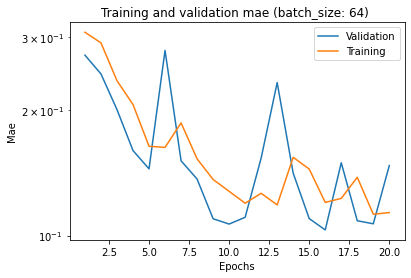

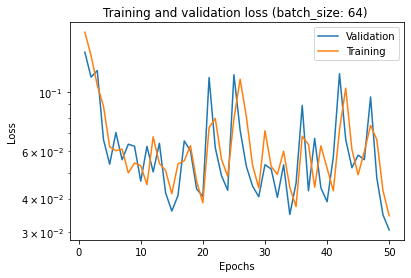

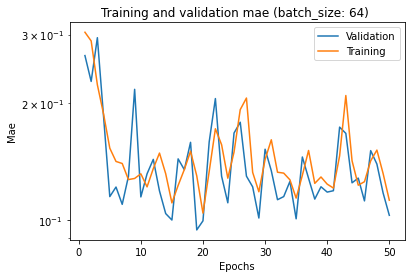

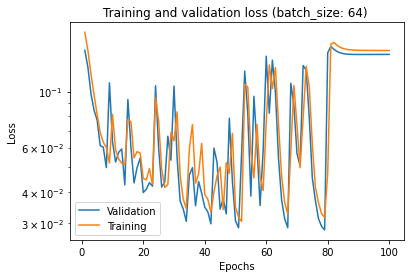

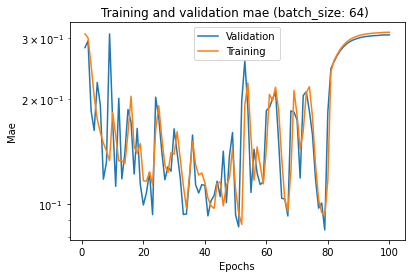

In [ ]:
#training a model with an input of just 2 bs

#load data for just 2brush strokes
paint_path2bs= TFM_path + '02_paintings_2bs/'
paint_path_out2bs= TFM_path +  '03_paintings_out_2bs/'
paint_path_in_test2bs= TFM_path + '05_test_2bs/IN/'
paint_path_out_test2bs= TFM_path + '05_test_2bs/OUT/'


data_2bs = load_images(path=paint_path2bs,gray=True)
target_2bs = load_results(path=paint_path_out2bs)

X_test_2bs = load_images(path=paint_path_in_test2bs, gray=True)
y_test_2bs= load_results(path=paint_path_out_test2bs)

model_training(gray_scale=True, model_id='model_128_2bs')




# Reviewing trained models

In [ ]:
#plotting from the saved csv with the resume of the training for each model.
def plot_from_summary(df_training, model_id_str):
  max_yvalue=np.max(df_training['val_loss'])
  for batchsize in df_training['batchsize'].unique():
    for epoch in df_training['total_epoch'].unique():  
      df_round=df_training[(df_training['batchsize']==batchsize) &  (df_training['total_epoch']==epoch)].sort_values(by =['epoch'])
      plt.plot( df_round['epoch'], df_round['loss'], color='orange')
      plt.plot( df_round['epoch'], df_round['val_loss'], color='green')
      plt.ylim([0, max_yvalue])
      plt.ylabel('Loss')
      plt.xlabel('epoch')
      plt.title(model_id_str + ' - batch size:' + str(batchsize) + ' epochs:' + str(epoch))       
      plt.show()  



"""
df_training=pd.read_csv(path_model + 'model_128gray_True.csv')
Summary_last_points= df_training[df_training['epoch']==df_training['total_epoch']].sort_values(by= ['loss'])
#plot_from_summary(df_training, 'model128')

df_training2=pd.read_csv(path_model + 'model_128gray_False.csv')
Summary_last_points2= df_training2[df_training2['epoch']==df_training2['total_epoch']].sort_values(by= ['loss'])

df_training3 = pd.read_csv(path_model + 'model_128avgpoolgray_True.csv')
Summary_last_points3= df_training3[df_training3['epoch']==df_training3['total_epoch']].sort_values(by= ['loss'])

# el path para los sigueintes modelos esta en 
path_model_plus= TFM_path + '04_models_plus/'
df_training4 = pd.read_csv(path_model_plus + 'model_128gray_True.csv')
Summary_last_points4= df_training4[df_training4['epoch']==df_training4['total_epoch']].sort_values(by= ['loss'])

df_training5 = pd.read_csv(path_model_plus + 'model_128avgpoolgray_True.csv')
Summary_last_points5= df_training5[df_training5['epoch']==df_training5['total_epoch']].sort_values(by= ['loss'])
"""

"\ndf_training=pd.read_csv(path_model + 'model_128gray_True.csv')\nSummary_last_points= df_training[df_training['epoch']==df_training['total_epoch']].sort_values(by= ['loss'])\n#plot_from_summary(df_training, 'model128')\n\ndf_training2=pd.read_csv(path_model + 'model_128gray_False.csv')\nSummary_last_points2= df_training2[df_training2['epoch']==df_training2['total_epoch']].sort_values(by= ['loss'])\n\ndf_training3 = pd.read_csv(path_model + 'model_128avgpoolgray_True.csv')\nSummary_last_points3= df_training3[df_training3['epoch']==df_training3['total_epoch']].sort_values(by= ['loss'])\n\n# el path para los sigueintes modelos esta en \npath_model_plus= TFM_path + '04_models_plus/'\ndf_training4 = pd.read_csv(path_model_plus + 'model_128gray_True.csv')\nSummary_last_points4= df_training4[df_training4['epoch']==df_training4['total_epoch']].sort_values(by= ['loss'])\n\ndf_training5 = pd.read_csv(path_model_plus + 'model_128avgpoolgray_True.csv')\nSummary_last_points5= df_training5[df_trai

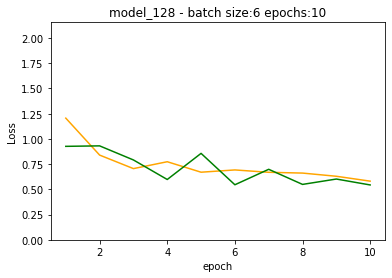

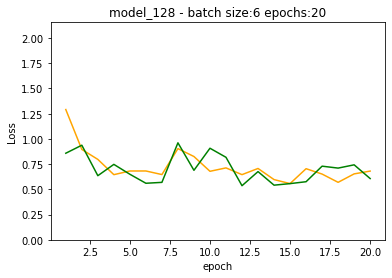

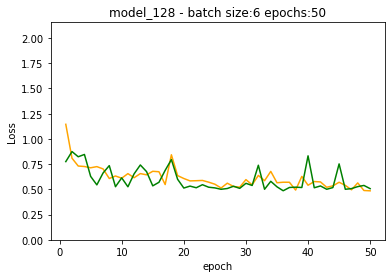

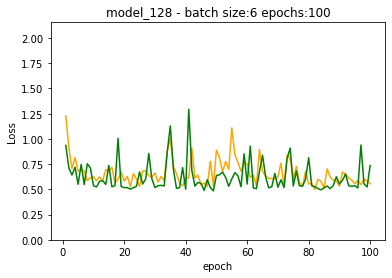

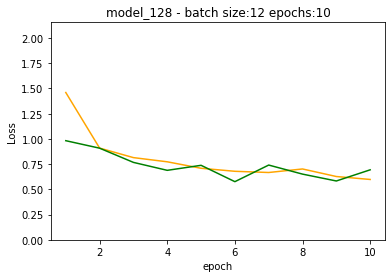

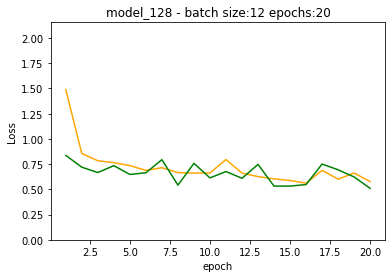

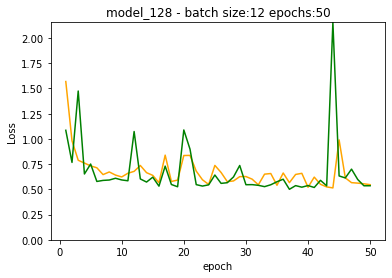

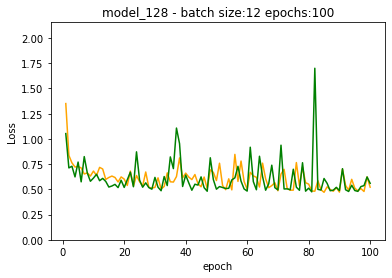

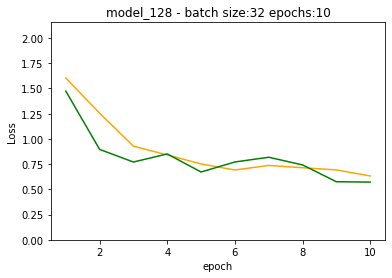

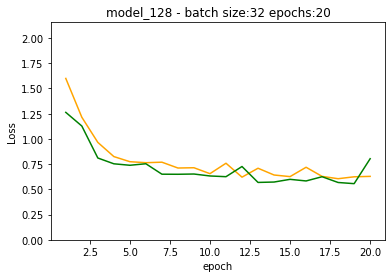

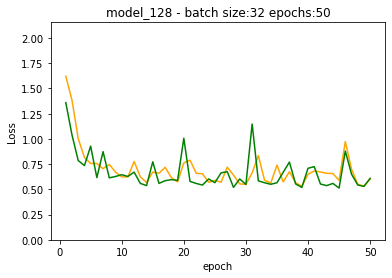

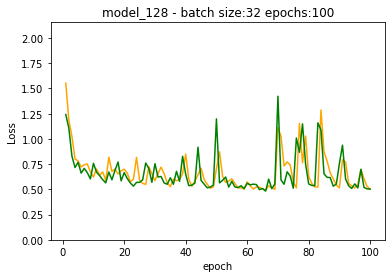

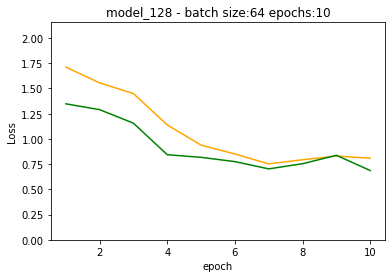

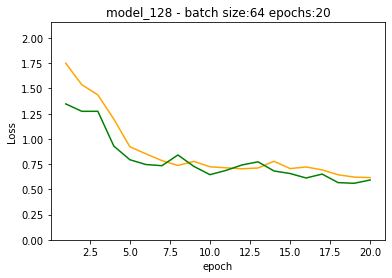

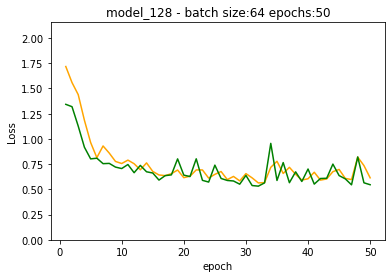

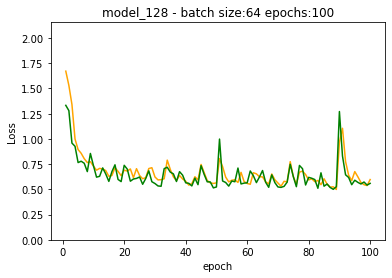

loss       mae  val_loss   val_mae     model_name  epoch  \
79   0.485347  0.410257  0.506777  0.417666  sequential_18     50   
539  0.503241  0.469180  0.502196  0.452644  sequential_27    100   
359  0.521358  0.453458  0.559799  0.415820  sequential_23    100   
259  0.546351  0.453164  0.535710  0.410170  sequential_22     50   
179  0.556193  0.462377  0.735874  0.487372  sequential_19    100   
209  0.576603  0.486587  0.509613  0.430321  sequential_21     20   
9    0.581184  0.471594  0.543557  0.428898  sequential_16     10   
719  0.597034  0.476501  0.559029  0.432008  sequential_31    100   
189  0.597979  0.494339  0.693461  0.684490  sequential_20     10   
439  0.602378  0.464088  0.608904  0.526791  sequential_26     50   
619  0.614064  0.524132  0.545778  0.504018  sequential_30     50   
569  0.616559  0.508140  0.592481  0.584772  sequential_29     20   
389  0.628536  0.500070  0.803586  0.498713  sequential_25     20   
369  0.632794  0.513997  0.571781  0.449558  sequential_24     10   
29   0.680998  0.539595  0.606880  0.615047  sequential_17     20   
549  0.808760  0.605776  0.686972  0.621721  sequential_28     10   

     total_epoch  batchsize  Ntrain_v_batchsize         model_in_code  
79            50          6                 107  model_128_avgpooling  
539          100         32                  20  model_128_avgpooling  
359          100         12                  54  model_128_avgpooling  
259           50         12                  54  model_128_avgpooling  
179          100          6                 107  model_128_avgpooling  
209           20         12                  54  model_128_avgpooling  
9             10          6                 107  model_128_avgpooling  
719          100         64                  10  model_128_avgpooling  
189           10         12                  54  model_128_avgpooling  
439           50         32                  20  model_128_avgpooling  
619           50         64                  10  model_128_avgpooling  
569           20         64                  10  model_128_avgpooling  
389           20         32                  20  model_128_avgpooling  
369           10         32                  20  model_128_avgpooling  
29            20          6                 107  model_128_avgpooling  
549           10         64                  10  model_128_avgpooling

In [ ]:
df_training=pd.read_csv(path_model + 'model_128gray_True.csv')
Summary_last_points= df_training[df_training['epoch']==df_training['total_epoch']].sort_values(by= ['loss'])

plot_from_summary(df_training, 'model_128')
Summary_last_points

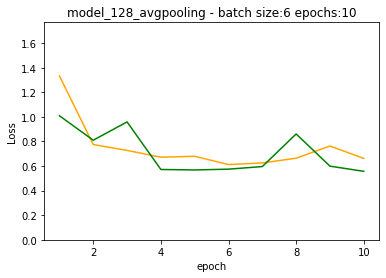

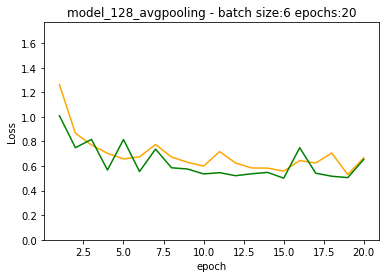

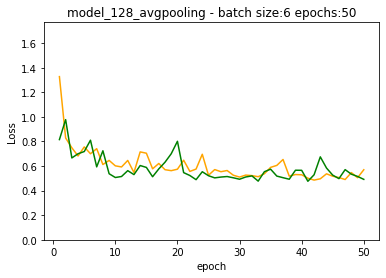

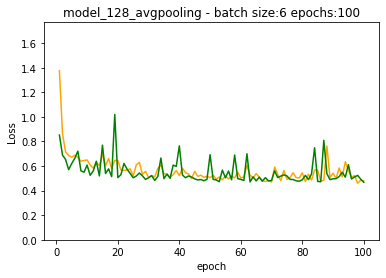

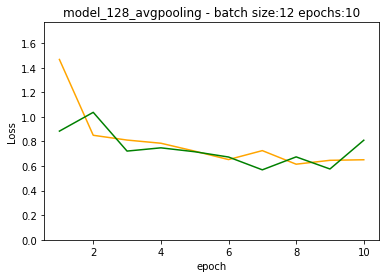

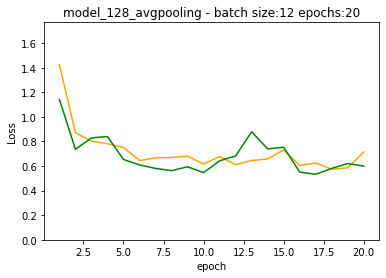

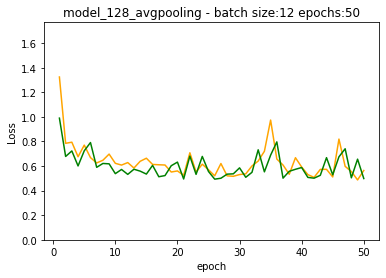

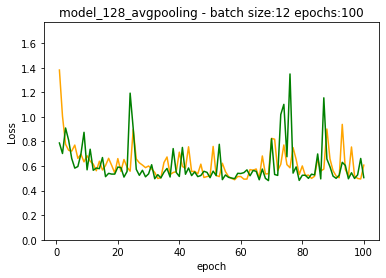

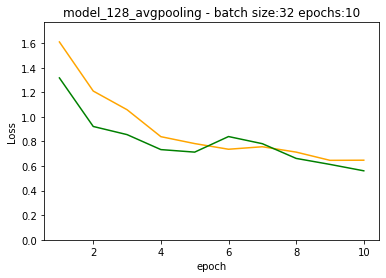

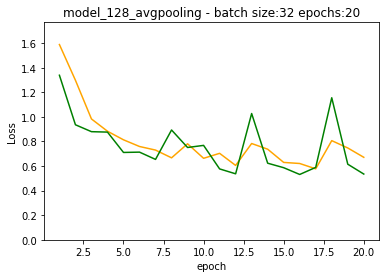

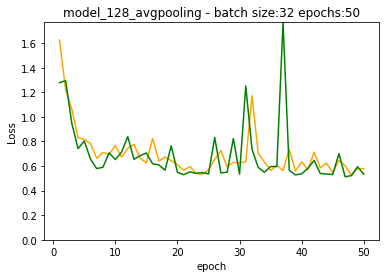

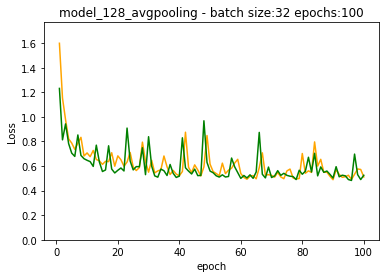

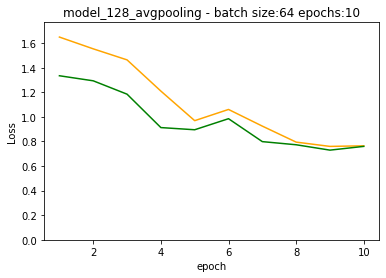

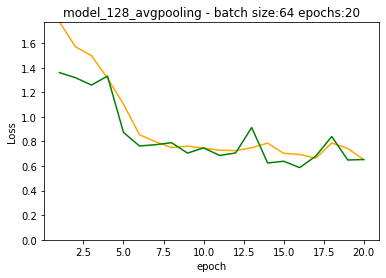

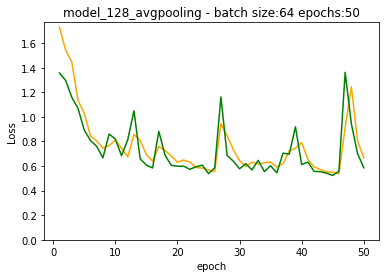

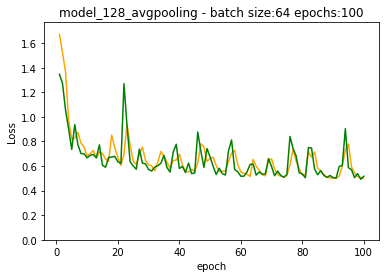

loss       mae  val_loss   val_mae     model_name  epoch  \
179  0.478490  0.406884  0.468091  0.385119   sequential_3    100   
719  0.499949  0.433296  0.516909  0.410326  sequential_15    100   
539  0.511739  0.439829  0.525160  0.419785  sequential_11    100   
259  0.563946  0.458243  0.498391  0.428689   sequential_6     50   
79   0.569922  0.454635  0.491807  0.418973   sequential_2     50   
439  0.576847  0.493212  0.534010  0.435274  sequential_10     50   
359  0.607503  0.479740  0.505960  0.426582   sequential_7    100   
369  0.647611  0.525974  0.561324  0.521916   sequential_8     10   
189  0.651244  0.520283  0.810217  0.780069   sequential_4     10   
569  0.652434  0.549253  0.652978  0.520316  sequential_13     20   
9    0.662216  0.536252  0.557114  0.440070     sequential     10   
619  0.665972  0.575369  0.586258  0.515413  sequential_14     50   
29   0.666914  0.517747  0.654347  0.538693   sequential_1     20   
389  0.671212  0.538009  0.534910  0.479626   sequential_9     20   
209  0.714634  0.565561  0.599492  0.484187   sequential_5     20   
549  0.764681  0.607591  0.760119  0.538115  sequential_12     10   

     total_epoch  batchsize  Ntrain_v_batchsize         model_in_code  
179          100          6                 107  model_128_avgpooling  
719          100         64                  10  model_128_avgpooling  
539          100         32                  20  model_128_avgpooling  
259           50         12                  54  model_128_avgpooling  
79            50          6                 107  model_128_avgpooling  
439           50         32                  20  model_128_avgpooling  
359          100         12                  54  model_128_avgpooling  
369           10         32                  20  model_128_avgpooling  
189           10         12                  54  model_128_avgpooling  
569           20         64                  10  model_128_avgpooling  
9             10          6                 107  model_128_avgpooling  
619           50         64                  10  model_128_avgpooling  
29            20          6                 107  model_128_avgpooling  
389           20         32                  20  model_128_avgpooling  
209           20         12                  54  model_128_avgpooling  
549           10         64                  10  model_128_avgpooling

In [ ]:
  
df_training3 = pd.read_csv(path_model + 'model_128avgpoolgray_True.csv')
Summary_last_points3= df_training3[df_training3['epoch']==df_training3['total_epoch']].sort_values(by= ['loss'])

plot_from_summary(df_training3, 'model_128_avgpooling')
Summary_last_points3

In [ ]:
df_training2 = pd.read_csv(path_model + 'model_128avgpoolgray_True.csv')
Summary_last_points2= df_training2[df_training2['epoch']==df_training2['total_epoch']].sort_values(by= ['loss'])

plot_from_summary(df_training2, 'model_128_avgpooling')
Summary_last_points2

# EVALUATION OF THE TRAINING

Define a function to re-evaluate the loss. 

The output should have distinguish by brush stroke (same value per each bs) so a measure is assigned by brush stroke, median of all values that belong to the same bs. 

After the assignment,the loss is evaluated together with the MAE

In [ ]:
# POST-PROCESS - output Y_test must be rearranged to unique values for the same brush stroke

#evaluate the model


from sklearn.metrics import mean_absolute_error as mae

def mae_func(imageA, imageB):
  err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
  err /= float(imageA.shape[0] * imageA.shape[1])

  mae = np.sum(np.absolute(imageA.astype("float") - imageB.astype("float")))
  mae /= float(imageA.shape[0] * imageA.shape[1])

  return err, mae




def evaluation(model_name,batch_size, epoch, gray):

  if model_name=='model_128_2bs':
           
    if gray==True:    
      X_train, X_val, y_train, y_val = train_test_split(data_2bs, target_2bs, test_size=0.2, random_state=42)
    else:
      X_train, X_val, y_train, y_val = train_test_split(data_rgb_2bs, target_2bs, test_size=0.2, random_state=42)

    X_test_db = X_test_2bs
    y_test_db = y_test_2bs

  else:  

    if gray==True:        
        X_train, X_val, y_train, y_val = train_test_split(data, target, test_size=0.2, random_state=42)
        X_test_db=X_test      
    else:
        X_train, X_val, y_train, y_val = train_test_split(data_rgb, target, test_size=0.2, random_state=42) 
        X_test_db=X_test_rgb    

    y_test_db = y_test

  model = keras.models.load_model(path_model + model_name + "gray_" + str(gray) + "_b" + str(batch_size) +"_e" + str(epoch) + ".h5")


  print('Evaluate on test data:', model_name)

  results = model.evaluate(X_train, y_train, batch_size=batch_size, verbose=0)
  print(f"train loss: %.3f, mae: %.3f" % (results[0], results[1]))

  results = model.evaluate(X_val, y_val, batch_size=batch_size, verbose=0)
  print(f"val   loss: %.3f, mae: %.3f" % (results[0], results[1]))
 

  results = model.evaluate(X_test_db, y_test_db, batch_size=batch_size, verbose=0)
  print(f"test  loss: %.3f, mae: %.3f" % (results[0], results[1]))




#procesado para recalcular la mae. Se transforma el output del modelo en una salida discreta en base a una métrica asociada a los bs: mediana.

  lst_mse=[]  # mae de cada test independientete
  lst_mse_new=[]
  lst_mae_skl=[]
  lst_mae_skl_new=[]

  predictions = model.predict(X_test_db)

  predictions_t=np.zeros_like(y_test_db)
  y_test_db_t=np.zeros_like(y_test_db)

  for idx in range(y_test_db.shape[0]):

    lst_colors=np.unique(X_test_db[idx]) # se extraen los distintos elementos del input, se hace por color poruqe no tenemos colores repetidos
    lst_colors=[i for i in lst_colors if i != 1. ] # se elimina el fondo - blanco
    

    #lst_median=[]
  
    
    for k in range(len(lst_colors)):
      
      mask_k = np.where(X_test_db[idx][:]==lst_colors[k])
      mean=np.mean ( predictions[idx][mask_k] )
      median=np.median ( predictions[idx][mask_k] )
      max=np.max ( predictions[idx][mask_k] )
      min=np.min ( predictions[idx][mask_k] )
      #lst_median.append(median)
      predictions_t[idx][mask_k]=median
      #print(f"gray_scale: %.3f, mean: %.3f, median: %.3f,max: %.3f, min: %.3f " % (lst_colors[k], mean, median, max, min))

    #reasigno los valores a numéricos del 1 a n
    unik_median=np.unique(predictions_t[idx])
    unik_median=[i for i in unik_median if i != 0. ]
    unik_median.sort()
    for i,k in enumerate(unik_median):
      predictions_t[idx][predictions_t[idx] == k]=i+1

    unik_ytest=np.unique(y_test_db[idx])
    unik_ytest=[i for i in unik_ytest if i != 0. ]
    unik_ytest.sort()
    for i,k in enumerate(unik_ytest):
      y_test_db_t[idx][y_test_db[idx] == k]=i+1

    #print(' ') #np.squeeze(predictions1[idx]
    mse, maec= mae_func(y_test_db[idx],np.squeeze(predictions)[idx])
    mse_new, mae_newc= mae_func(y_test_db_t[idx], predictions_t[idx])
    lst_mse.append(mse)
    lst_mse_new.append(mse_new)

    mae_skl =  mae(y_test_db[idx], np.squeeze(predictions [idx]))    
    lst_mae_skl.append(mae_skl)
    mae_skl_new = mae(y_test_db_t[idx], predictions_t[idx])
    lst_mae_skl_new.append(mae_skl_new)

    #print(f"test_id:%.0f   --> mse: %.3f, mae: %.3f, new mse: %.3f, new mae: %.3f" % (idx, mse, mae_skl, mse_new, mae_skl_new))
    #print('predictions idx',idx, 'mse: ',mse , 'mae:', mae, '.Predictions transformed idx',idx, 'mse: ',mse_new , 'mae:', mae_new)
    #print('predictions transformed idx',idx, 'mse: ',mse_new , 'mae:', mae_new)


  MAE = np.mean(lst_mae_skl)
  MAE_NEW = np.mean(lst_mae_skl_new)

  MSE = np.mean(lst_mse)
  MSE_NEW = np.mean(lst_mse_new)
  Accuracy= len(np.where(lst_mse_new[:]==0. )) /len(lst_mse_new)

  
  print(' ')
  print(f"MSE    :%.3f  MAE    :%.3f" % (MSE, MAE))
  print(f"MSE_NEW:%.3f  MAE_NEW:%.3f Accuracy:%.3f" % (MSE_NEW, MAE_NEW, Accuracy))   
  print(' ')

  return predictions_t

In [ ]:
y_test_t1 = evaluation(model_name='model_128avgpool',batch_size=32,epoch=100, gray=True)
y_test_t2 = evaluation (model_name='model_128',batch_size=12,epoch=100, gray=True)
#y_test_t3 = evaluation (model_name='model_128',batch_size=12,epoch=100, gray=False)
y_test_t4 = evaluation (model_name='model_128_2bs',batch_size=12,epoch=100, gray=True) #64,50


Evaluate on test data: model_128avgpool
train loss: 0.047, mae: 0.140
val   loss: 0.055, mae: 0.150
test  loss: 0.045, mae: 0.138
7/7 [==============================] - 2s 306ms/step
 
MSE    :0.045  MAE    :0.138
MSE_NEW:1.047  MAE_NEW:0.536 Accuracy:0.005
 
Evaluate on test data: model_128
train loss: 0.047, mae: 0.132
val   loss: 0.053, mae: 0.138
test  loss: 0.046, mae: 0.130
7/7 [==============================] - 2s 304ms/step
 
MSE    :0.046  MAE    :0.130
MSE_NEW:0.746  MAE_NEW:0.441 Accuracy:0.005
 
Evaluate on test data: model_128_2bs
train loss: 0.027, mae: 0.080
val   loss: 0.025, mae: 0.077
test  loss: 0.028, mae: 0.081
10/10 [==============================] - 3s 321ms/step
 
MSE    :0.028  MAE    :0.081
MSE_NEW:0.124  MAE_NEW:0.124 Accuracy:0.003
 


In [ ]:
y_test_t1 = evaluation(model_name='model_128avgpool',batch_size=64,epoch=100, gray=True)
y_test_t2 = evaluation (model_name='model_128',batch_size=64,epoch=100, gray=True)
#y_test_t3 = evaluation (model_name='model_128',batch_size=6,epoch=100, gray=False)
y_test_t4 = evaluation (model_name='model_128_2bs',batch_size=64,epoch=50, gray=True) #64,50


Evaluate on test data: model_128avgpool
train loss: 0.048, mae: 0.148
val   loss: 0.057, mae: 0.159
test  loss: 0.047, mae: 0.147
7/7 [==============================] - 2s 313ms/step
 
MSE    :0.190  MAE    :0.311
MSE_NEW:3.880  MAE_NEW:1.201
 
Evaluate on test data: model_128
train loss: 0.051, mae: 0.155
val   loss: 0.059, mae: 0.164
test  loss: 0.050, mae: 0.154
7/7 [==============================] - 2s 305ms/step
 
MSE    :0.173  MAE    :0.299
MSE_NEW:4.015  MAE_NEW:1.228
 
Evaluate on test data: model_128_2bs
train loss: 0.032, mae: 0.105
val   loss: 0.031, mae: 0.103
test  loss: 0.033, mae: 0.106
10/10 [==============================] - 3s 323ms/step
 
MSE    :0.150  MAE    :0.220
MSE_NEW:0.548  MAE_NEW:0.340
 


# Display of the results by ploting:
- original image
- target 
- model_1 result
- ..
- model_n result

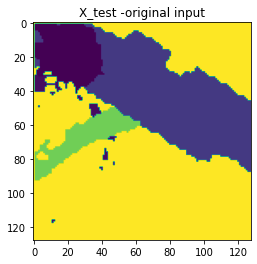

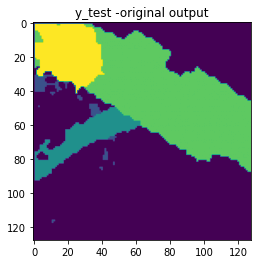

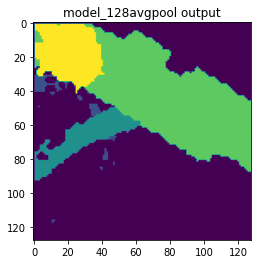

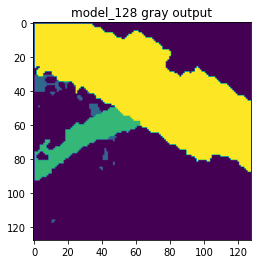

NameError: ignored

In [ ]:
#plot output by model for any sample in test to check how the models behave

idx=21 #selection of the sample index

plt.imshow(X_test[idx])
plt.title('X_test -original input')
plt.show()

plt.imshow(y_test[idx])
plt.title('y_test -original output')
plt.show()

plt.imshow(y_test_t1[idx])
plt.title('model_128avgpool output')
plt.show()

plt.imshow(y_test_t2[idx])
plt.title('model_128 gray output')
plt.show()

plt.imshow(y_test_t3[idx])
plt.title('model_128 rgb output')
plt.show()


from matplotlib.colors import ListedColormap
import seaborn as sns

my_colors = ['white', 'red', 'blue', 'green', 'yellow']
my_cmap = ListedColormap(sns.color_palette(my_colors))

plt.contourf(y_test[idx], cmap=my_cmap, levels=4)
plt.title('y_test')
plt.colorbar() 
plt.show()

plt.contourf(y_test_t1[idx], cmap=my_cmap, levels=4)
plt.title('model_128avgpool')
plt.colorbar() 
plt.show()


plt.contourf(y_test_t2[idx], cmap=my_cmap, levels=4)
plt.colorbar() 
plt.title('model_128')
plt.show()


plt.contourf(y_test_t3[idx], cmap=my_cmap, levels=4)
plt.colorbar() 
plt.title('model_128')
plt.show()




In [ ]:
np.unique(y_test_t4[idx])

array([0.        , 0.64446115, 0.88833791])

# PRE-TRAINED MODEL -pending task!!
_________


In [ ]:
from keras.applications import vgg19


 ## Export the results on a single image to excel. The results by model tested ,and target, are later coloured by their values in order to find possible patterns.

In [ ]:
#Code to export the results to a csv in order to check on the outputs -Testing

!pip install xlsxwriter

path_model1='/content/drive/MyDrive/TFM/04_models/'
path_model2='/content/drive/MyDrive/TFM/04_models_plus/'

model1 = keras.models.load_model(path_model1 + "model_128gray_True_b" + str(batch_size) +"_e" + str(epoch) + ".h5")
model2 = keras.models.load_model(path_model1 + "model_128gray_False_b" + str(batch_size) +"_e" + str(epoch) + ".h5")
model3 = keras.models.load_model(path_model1 + "model_128avgpoolgray_True_b" + str(batch_size) +"_e" + str(epoch) + ".h5")
model4 = keras.models.load_model(path_model2 + "model_128gray_True_b" + str(batch_size) +"_e" + str(epoch) + ".h5")
model5 = keras.models.load_model(path_model2 + "model_128avgpoolgray_True_b" + str(batch_size) +"_e" + str(epoch) + ".h5")


idx=9

#predicitions
predictions1 = model1.predict(X_test)
predictions2 = model2.predict(X_test_rgb)
predictions3 = model3.predict(X_test)
predictions4 = model4.predict(X_test)
predictions5 = model5.predict(X_test)

df_model1= pd.DataFrame.from_records(np.squeeze(predictions1[idx]) )
df_model2= pd.DataFrame.from_records(np.squeeze(predictions2[idx]) )
df_model3= pd.DataFrame.from_records(np.squeeze(predictions3[idx]) )
df_model4= pd.DataFrame.from_records(np.squeeze(predictions4[idx]) )
df_model5= pd.DataFrame.from_records(np.squeeze(predictions5[idx]) )

df_target= pd.DataFrame.from_records(y_test[idx]) 

# Create some Pandas dataframes from some data.

Target =pd.DataFrame(df_target)


# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter(path_model + 'testing_oputput_128_b' + str(batch_size) + "_e" + str(epoch) + "_id" + str(idx) + '.xlsx', engine='xlsxwriter')

# Write each dataframe to a different worksheet.
df_model1.to_excel(writer, sheet_name='grayTrue_b' + str(batch_size) + "_e" + str(epoch))
df_model2.to_excel(writer, sheet_name='grayFalse_b' + str(batch_size) + "_e" + str(epoch))
df_model3.to_excel(writer, sheet_name='avgpoolgrayTrue_b' + str(batch_size) + "_e" + str(epoch))
df_model4.to_excel(writer, sheet_name='plusgrayTrue_b' + str(batch_size) + "_e" + str(epoch))
df_model5.to_excel(writer, sheet_name='plusavgpoolgrayTrue_b' + str(batch_size) + "_e" + str(epoch))

Target.to_excel(writer, sheet_name='Target')


# Close the Pandas Excel writer and output the Excel file.
writer.close()



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
7/7 [==============================] - 0s 14ms/step


In [ ]:

#post procesado___________________
#https://stackoverflow.com/questions/69842877/masking-a-python-2d-array-to-change-values-in-a-circle-under-a-certain-threshold

#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

#CONCLUSION## 

### To continue with this training requires to invert much more time than expected so this projects is on hold at the moment.